In [1]:
import random

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.graphics.tsaplots import plot_acf

from src.agents import ETFTrader, FundamentalTrader, TrendTrader, MeanReversionTrader, ZeroIntelligenceTrader
from src.core import Engine

In [2]:
TOTAL_CASH = 1_000_000
ZI_SHARE = 0.3642
TECH_TREND_SHARE = 0.1686
TECH_REVERSION_SHARE = 0.0321
FUNDAMENTAL_SHARE = 0.1715
ETF_SHARE = 0.2636
assert ZI_SHARE + TECH_TREND_SHARE + TECH_REVERSION_SHARE + FUNDAMENTAL_SHARE + ETF_SHARE == 1

INITIAL_PRICE = 100
N_STEPS = 500

# Симуляция в нормальных условиях

In [3]:
def init_zi_agents(cash: float = 500, noise: float = 0.1) -> list[ZeroIntelligenceTrader]:
    return [
        ZeroIntelligenceTrader(
            cash=cash, 
            noise=noise,
        ) for i in range(round(TOTAL_CASH * ZI_SHARE / cash))
    ]

def init_tech_trend_agents(windows_size: list[int] = [6, 7, 8, 9], pct: float = 0.05) -> list[TrendTrader]:
    return [
        TrendTrader(
            cash=(TOTAL_CASH * TECH_TREND_SHARE) * (window_size / sum(windows_size)), 
            window_size=window_size,
            pct=pct,
        ) for window_size in windows_size
    ]

def init_tech_reversion_agents(windows_size: list[int] = [2, 3, 4, 5], pct: float = 0.05) -> list[MeanReversionTrader]:
    return [
        MeanReversionTrader(
            cash=(TOTAL_CASH * TECH_REVERSION_SHARE) * (window_size / sum(windows_size)), 
            window_size=window_size,
            pct=pct,
        ) for window_size in windows_size
    ]

def init_fundamental_agents(
    mu: float = 0.000172, 
    sigma: float = 0.000193, 
    min: float = -0.000624, 
    max: float = 0.000624,
    pct: float = 0.05,
) -> list[FundamentalTrader]:
    return [
        FundamentalTrader(
            cash=TOTAL_CASH * FUNDAMENTAL_SHARE,
            mu=mu,
            sigma=sigma,
            pct=pct,
            min=min,
            max=max,
        )
    ]

def init_etf_agents(pct: float = 0.1) -> list[ETFTrader]:
    return [
        ETFTrader(
            cash=TOTAL_CASH * ETF_SHARE,
            pct=pct,
        )
    ]

In [4]:
random.seed(777)

engine = Engine()
engine.run(
    agents=(
        init_zi_agents()
        + init_tech_trend_agents()
        + init_tech_reversion_agents()
        + init_fundamental_agents()
        + init_etf_agents()
    ),
    initial_price=INITIAL_PRICE,
    n_steps=N_STEPS,
)

100%|████████████████████████████████████████| 500/500 [00:04<00:00, 108.09it/s]


## Визуализация и анализ

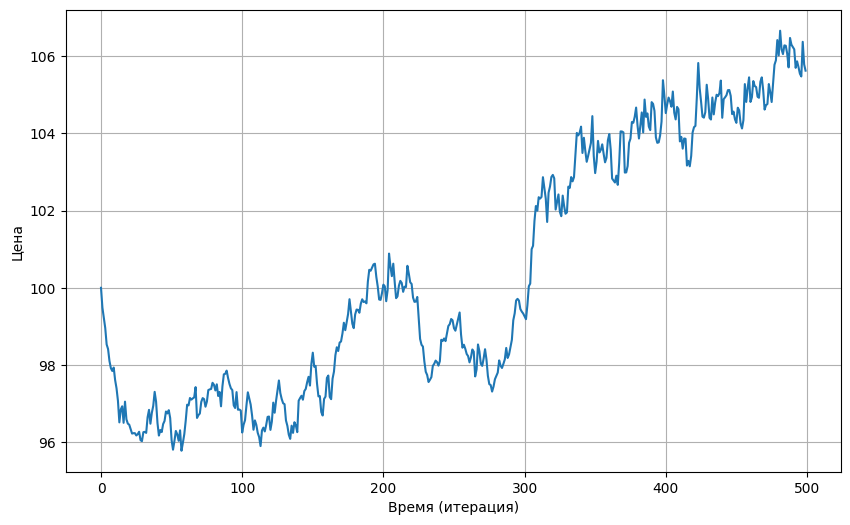

In [5]:
price = pd.Series(engine.stats_monitor.prices)
price.plot(
    ylabel="Цена",
    xlabel="Время (итерация)",
    grid=True,
    figsize=(10, 6),
);

In [22]:
price.to_csv("price.csv")

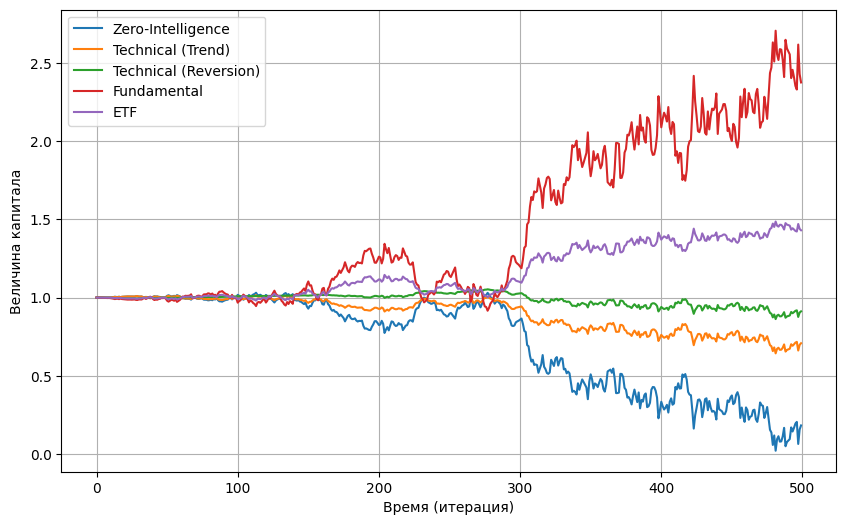

In [6]:
equity = pd.DataFrame(
    [
        [
            bs[ZeroIntelligenceTrader]["total_equity"],
            bs[TrendTrader]["total_equity"],
            bs[MeanReversionTrader]["total_equity"],
            bs[FundamentalTrader]["total_equity"],
            bs[ETFTrader]["total_equity"],
        ]
        for bs in engine.stats_monitor.balance_stats
    ],
    columns=[
        "Zero-Intelligence", 
        "Technical (Trend)", 
        "Technical (Reversion)", 
        "Fundamental", 
        "ETF",
    ],
)
(equity / equity.iloc[0].to_numpy()[None, :]).plot(
    xlabel="Время (итерация)",
    ylabel="Величина капитала",
    grid=True,
    figsize=(10, 6),
);

## Проверка стилизованных фактов

### Лептокуртическое распределение доходности

In [7]:
price.pct_change().kurt()

0.41012741138435205

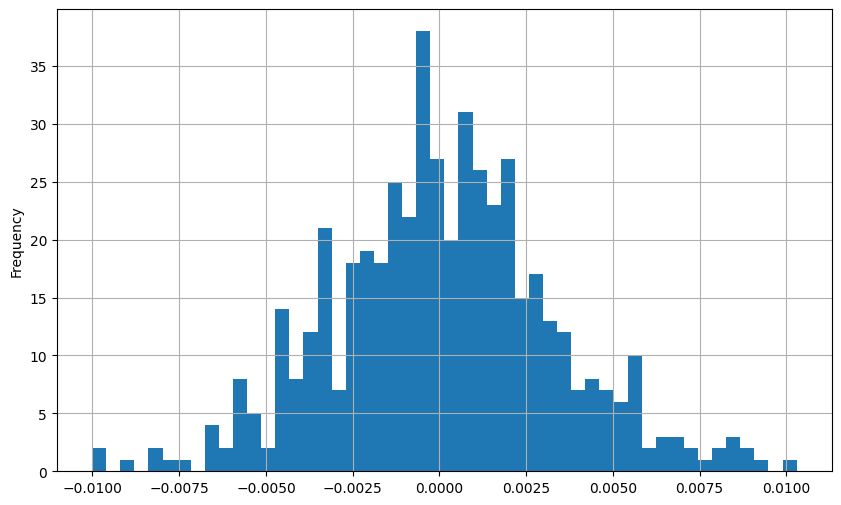

In [8]:
price.pct_change().plot.hist(
    bins=50,
    figsize=(10, 6),
    grid=True,
);

### Отсутствие автокорреляции доходностей

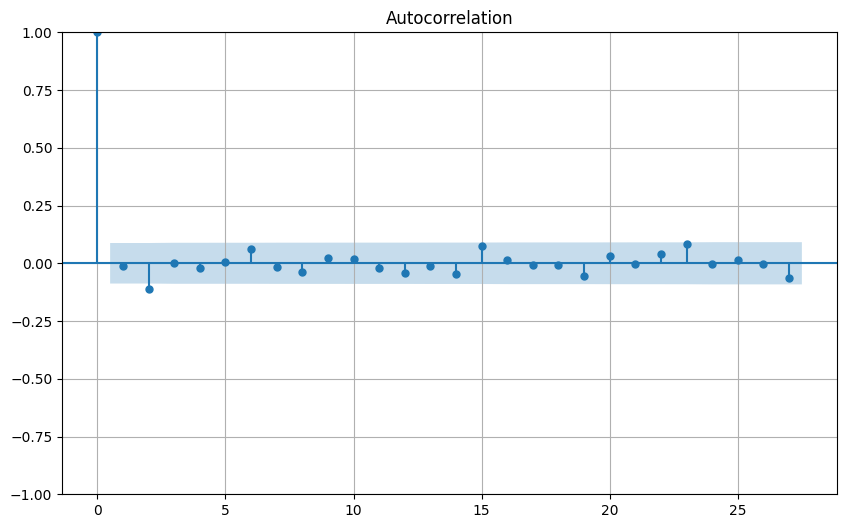

In [9]:
fig, ax = plt.subplots(figsize=(10, 6))
plot_acf(price.pct_change().dropna(), ax=ax)
plt.grid();

### Кластеризация волатильности

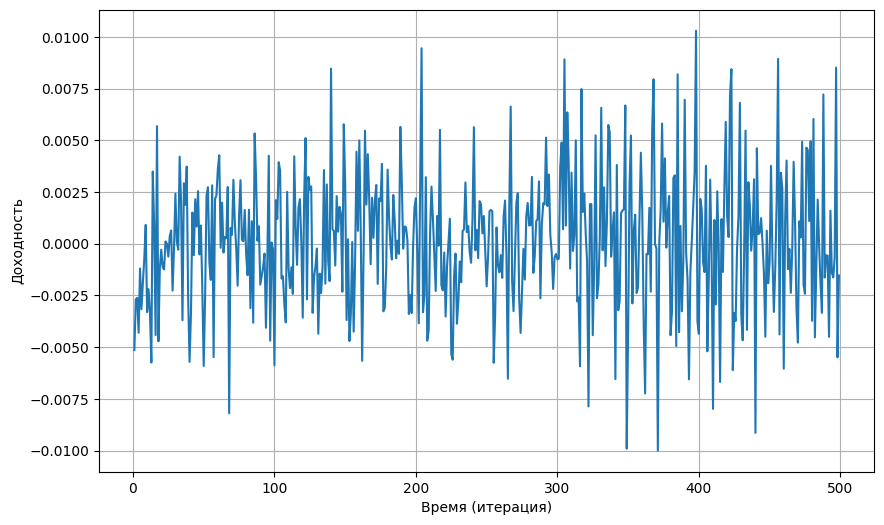

In [10]:
price.pct_change().plot(
    grid=True,
    figsize=(10, 6),
    xlabel="Время (итерация)",
    ylabel="Доходность",
);

### Асимметрия волатильности

In [11]:
volatility = pd.DataFrame(
    [(INITIAL_PRICE, None)] + [(ps["mean_weighted_price"], ps["std_price"]) for ps in engine.stats_monitor.period_stats],
    columns=["price", "std"],
)
volatility["returns"] = volatility["price"].pct_change()
volatility[["returns", "std"]].dropna().corr().iloc[0, 1]

-0.0042442473040921885

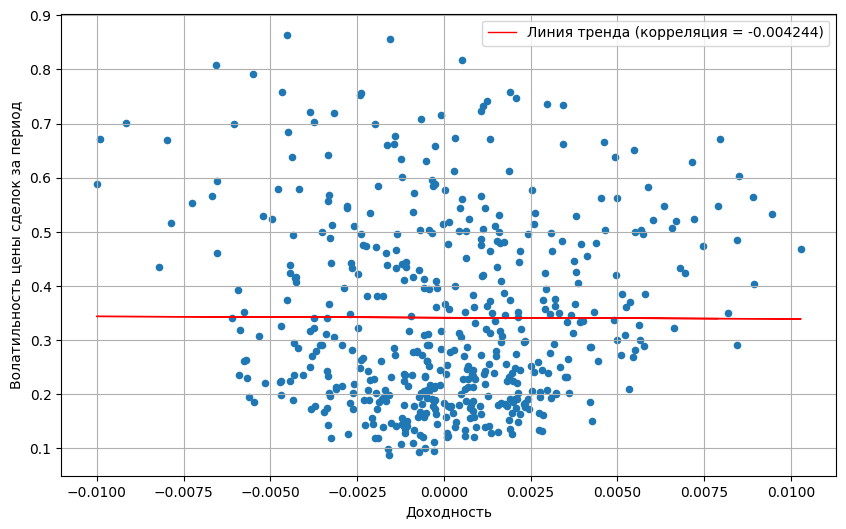

In [12]:
fig, ax = plt.subplots(figsize=(10, 6))
trend = np.poly1d(np.polyfit(volatility["returns"].dropna(), volatility["std"].dropna(), deg=1))

volatility[["returns", "std"]].plot.scatter(
    x="returns", y="std", ax=ax, 
    grid=True,
    xlabel="Доходность",
    ylabel="Волатильность цены сделок за период",
)

plt.plot(
    volatility["returns"].dropna(), 
    trend(volatility["returns"].dropna()), 
    linewidth=1, 
    color="r",
    label=f"Линия тренда (корреляция = {volatility[['returns', 'std']].dropna().corr().iloc[0, 1]:6f})"
)
plt.legend();

### Автокорреляция торгового объема

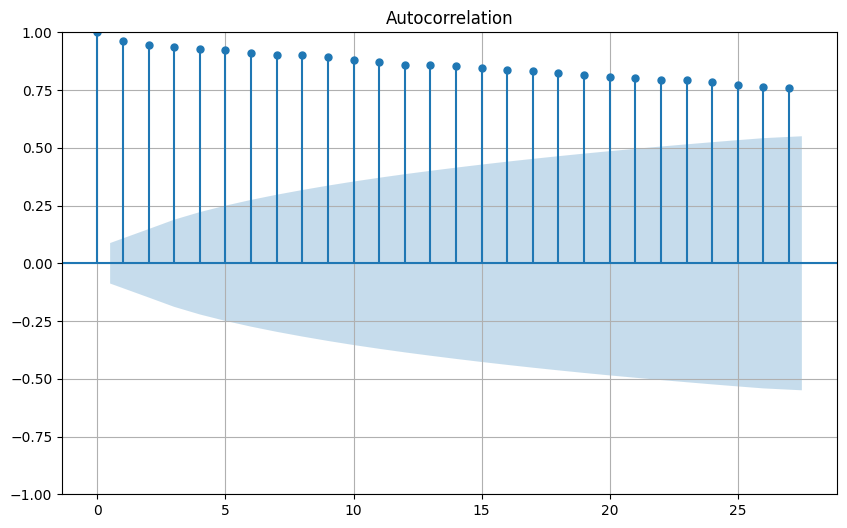

In [13]:
volumes = pd.Series([ps["total_quantity"] for ps in engine.stats_monitor.period_stats])
fig, ax = plt.subplots(figsize=(10, 6))
plot_acf(volumes, ax=ax)
plt.grid();

### Корреляция между торговым объемом и волатильностью

In [14]:
volatility_volumes = pd.DataFrame()
volatility_volumes["std"] = volatility["std"].dropna()
volatility_volumes["volume"] = volumes
volatility_volumes = volatility_volumes.dropna()
volatility_volumes.corr().iloc[0, 1]

-0.7719809789616727

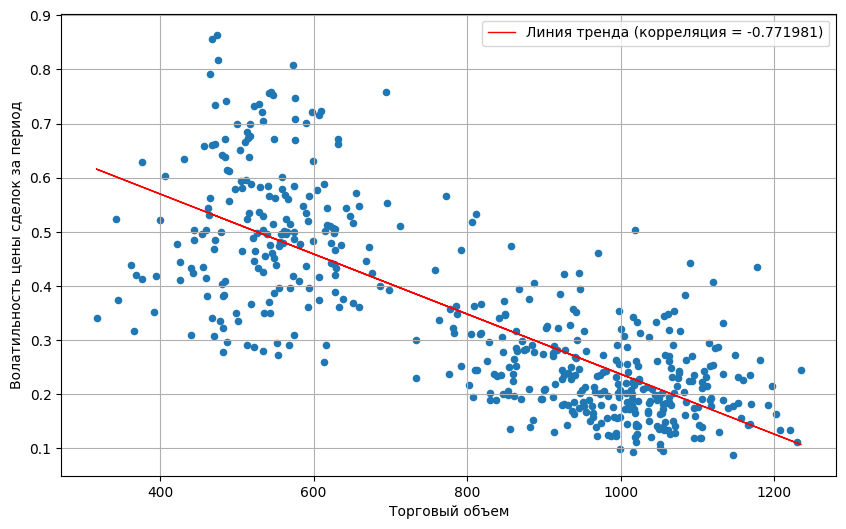

In [15]:
fig, ax = plt.subplots(figsize=(10, 6))
trend = np.poly1d(np.polyfit(volatility_volumes["volume"].dropna(), volatility_volumes["std"].dropna(), deg=1))

volatility_volumes[["volume", "std"]].plot.scatter(
    x="volume", y="std", ax=ax, 
    grid=True,
    xlabel="Торговый объем",
    ylabel="Волатильность цены сделок за период",
)

plt.plot(
    volatility_volumes["volume"].dropna(), 
    trend(volatility_volumes["volume"].dropna()), 
    linewidth=1, 
    color="r",
    label=f"Линия тренда (корреляция = {volatility_volumes[['volume', 'std']].dropna().corr().iloc[0, 1]:6f})"
)
plt.legend();